In [7]:
# Important libraries
from langchain_experimental.agents import create_pandas_dataframe_agent
from langchain.agents import AgentType
from langchain_openai import ChatOpenAI

import pandas as pd

In [8]:
# Custom date parser function
df_movie = pd.read_csv("movies_meta.csv")
df_movie

,original_title,release_date,collection,genres
0,Toy Story,1995-10-30,Toy Story Collection,"['Animation', 'Comedy', 'Family']"
1,Jumanji,1995-12-15,NaN,"['Adventure', 'Fantasy', 'Family']"
2,Grumpier Old Men,1995-12-22,Grumpy Old Men Collection,"['Romance', 'Comedy']"
3,Waiting to Exhale,1995-12-22,NaN,"['Comedy', 'Drama', 'Romance']"
4,Father of the Bride Part II,1995-02-10,Father of the Bride Collection,['Comedy']
...,...,...,...,...
45461,رگ خواب,NaN,NaN,"['Drama', 'Family']"
45462,Siglo ng Pagluluwal,2011-11-17,NaN,['Drama']
45463,Betrayal,2003-08-01,NaN,"['Action', 'Drama', 'Thriller']"
45464,Satana likuyushchiy,1917-10-21,NaN,[]


In [9]:
df_movie.release_date = pd.to_datetime(df_movie["release_date"], errors="coerce")
df_movie

,original_title,release_date,collection,genres
0,Toy Story,1995-10-30,Toy Story Collection,"['Animation', 'Comedy', 'Family']"
1,Jumanji,1995-12-15,NaN,"['Adventure', 'Fantasy', 'Family']"
2,Grumpier Old Men,1995-12-22,Grumpy Old Men Collection,"['Romance', 'Comedy']"
3,Waiting to Exhale,1995-12-22,NaN,"['Comedy', 'Drama', 'Romance']"
4,Father of the Bride Part II,1995-02-10,Father of the Bride Collection,['Comedy']
...,...,...,...,...
45461,رگ خواب,NaT,NaN,"['Drama', 'Family']"
45462,Siglo ng Pagluluwal,2011-11-17,NaN,['Drama']
45463,Betrayal,2003-08-01,NaN,"['Action', 'Drama', 'Thriller']"
45464,Satana likuyushchiy,1917-10-21,NaN,[]


In [10]:
# initiate llm
llm = ChatOpenAI(
    model = 'gpt-4o-mini',
    max_tokens = 1000,
    temperature=0
)

In [15]:
agent = create_pandas_dataframe_agent(
    llm,
    df = df_movie,
    # verbose=True,
    allow_dangerous_code=True,
    agent_type=AgentType.OPENAI_FUNCTIONS   
)
print("Data Analysis Agent is ready. You can now ask questions about the data.")

Data Analysis Agent is ready. You can now ask questions about the data.


In [16]:
def ask_agent(question):
    """Function to ask questions to the agent and display the response"""
    response = agent.run({
        "input": question,
        "agent_scratchpad": f"Human: {question}\nAI: To answer this question, I need to use Python to analyze the dataframe. I'll use the python_repl_ast tool.\n\nAction: python_repl_ast\nAction Input: ",
    })
    # print(f"Question: {question}")
    # print(f"Answer: {response}")
    # print("---")
    return response

In [18]:
from IPython.display import Markdown
Markdown(ask_agent("what are the column names of in this dataset, show in tabular form"))

Here are the column names of the dataset in tabular form:

|   | Column Names      |
|---|-------------------|
| 0 | original_title    |
| 1 | release_date      |
| 2 | collection        |
| 3 | genres            |

In [19]:
Markdown(ask_agent("What is the timeperiod of movies, give in year"))

The time period of the movies in the dataframe spans from the year 1874 to 2020.

In [20]:
Markdown(ask_agent("get the number of movies per each year, plot a bar graph using plotly, don't give me code"))

I have generated a bar graph showing the number of movies released per year using Plotly. You can view the graph to analyze the distribution of movie releases over the years.

In [96]:
from langgraph.graph import MessagesState
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

In [97]:
# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with anlayzing dataframes")

In [103]:
def assistant(state : MessagesState):
    return {"messages" :  ask_agent([sys_msg] + state["messages"])}

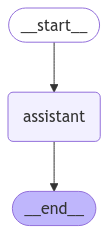

In [104]:
from langgraph.graph import START, StateGraph, MessagesState, END
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_edge("assistant", END)
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [105]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
react_graph_memory = builder.compile(checkpointer=memory)

In [106]:
# Specify a thread
config = {"configurable": {"thread_id": "11"}}

# Specify an input
messages = [HumanMessage(content="What are the attributes present")]

# Run
messages = react_graph_memory.invoke({"messages": messages},config)

In [107]:
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

What are the attributes present
================================ Human Message =================================

The attributes present in the dataframe `df` are as follows:

1. **original_title**: The title of the movie.
2. **release_date**: The date the movie was released.
3. **collection**: The name of the collection the movie belongs to, if any.
4. **genres**: The genres associated with the movie, represented as a list. 

These attributes provide information about each movie in the dataframe.


In [108]:
# Specify an input
messages = [HumanMessage(content="get the number of movies per each year, plot a bar graph using plotly")]

# Run
messages = react_graph_memory.invoke({"messages": messages},config)

In [109]:
messages

{'messages': [HumanMessage(content='What are the attributes present', additional_kwargs={}, response_metadata={}, id='45df305f-1027-4439-8ef2-0b0c1f1e5509'),
  HumanMessage(content='The attributes present in the dataframe `df` are as follows:\n\n1. **original_title**: The title of the movie.\n2. **release_date**: The date the movie was released.\n3. **collection**: The name of the collection the movie belongs to, if any.\n4. **genres**: The genres associated with the movie, represented as a list. \n\nThese attributes provide information about each movie in the dataframe.', additional_kwargs={}, response_metadata={}, id='8fdc1ee1-2ec7-44d6-9fab-512c9c67e924'),
  HumanMessage(content='get the number of movies per each year, plot a bar graph using plotly', additional_kwargs={}, response_metadata={}, id='1f1093c8-e9b6-4dec-83bf-3d19e6346870'),
  HumanMessage(content='The bar graph displaying the number of movies released per year has been generated successfully. You can view the trends in 

In [110]:
import os
# Directory for storing conversation histories
CONVERSATION_HISTORY_DIR = "conversation_histories"
os.makedirs(CONVERSATION_HISTORY_DIR, exist_ok=True)

In [111]:
import json
def save_conversation(thread_id, conversation):
    """Save the conversation to a local JSON file based on the thread_id"""
    file_path = os.path.join(CONVERSATION_HISTORY_DIR, f"{thread_id}.json")
    with open(file_path, "w") as f:
        json.dump(conversation, f, indent=4)

In [112]:
messages_list = [ele.content for ele in messages["messages"]]

In [119]:
messages_json = json.dumps(messages_list)

In [118]:
save_conversation(11, messages_json)